In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

A common assumption is that stock prices follow a Geometric Brownian Motion, i.e. the logarithm of a stock's price performs a random walk. In this notebook, we define a simulation algorithm to generate a multidimensional geometric brownian movement.

## 1. Mathematical Formulation of the Geometric Brownian Movement

A multidimensional geometric brownian movement $S=(S_{1},...,S_{d})$ is defined by the following equation : 
\begin{equation}
    \frac{d S_{i}(t)}{S(t)}=\mu d t+\sigma_{i} d W_{i}(t).
\end{equation}
where B is a brownian motion, $\mu \in \mathbb{R}$ and $\sigma \in \mathbb{R}^{+*}$.

Let us note $Corr(W_{i}, W_{j}) = \rho_{ij}$. In order to generate S, we will use the following algorithm, defined in the book *Monte Carlo Methods for Financial Engineering* :
1. Compute the covariance matrix $\Sigma$, $\Sigma_{ij} = \sigma_{i}\sigma_{j}\rho_{ij}$
2. Compute a matrix A such that $AA^{T} = \Sigma$, in this case $\frac{d S_{i}(t)}{S_{i}(t)}=\mu_{i} d t+\sum_{j=1}^{d} A_{i j} d W_{j}(t)$
3. Compute $S_{i}\left(t_{k+1}\right)=S_{i}\left(t_{k}\right) e^{\left(\mu_{i}-\frac{1}{2} \sigma_{i}^{2}\right)\left(t_{k+1}-t_{k}\right)+\sqrt{t_{k+1}-t_{k}} \sum_{j=1}^{d} A_{i j} Z_{k+1, j}}$ where $Z_{k}=\left(Z_{k 1}, \ldots, Z_{k d}\right) \sim N(0, I)$ and $Z_{1},...,Z_{d}$ are independant random variables

In order to optimize computation time, the matrix $A$ is usually taken as the Cholesky decomposition of $\Sigma$. This recquires $\Sigma$ to be a symetric positive definite matrix.

## 2. Geometric Brownian Movement Simulation

In [3]:
def cov_matrix(sigmas, corrs) :
    """ Builds the covariance matrix
      sigmas : (sigma1, sigma2,...,sigmad) the volatilities
      corrs : matrix dxd containing the correlations corrs[i][j] = corr(dWi, dWj)
    """
    sigma = []
    d = len(sigmas)
    for i in range(d) :
        l = []
        for j in range(d) :
            l.append(sigmas[i]*sigmas[j]*corrs[i][j])
        sigma.append(l)
    return sigma

# In case the covariance matrix is not immediately a positive-definte matrix, we use the following algorithm to compute the nearest 
# symetric definite matrix to Sigma
def nearestPD(A):
    """Find the nearest (for the Frobenius norm) positive-definite matrix to input

    A Python/Numpy port of John D'Errico's `nearestSPD` MATLAB code [1], which
    credits [2] 
    
    [1] https://www.mathworks.com/matlabcentral/fileexchange/42885-nearestspd

    [2] N.J. Higham, "Computing a nearest symmetric positive semidefinite
    matrix" (1988): https://doi.org/10.1016/0024-3795(88)90223-6

    A : list or np.array, symmetric
    """
    
    A = np.asarray(A)
    _, s, V = np.linalg.svd(A)

    H = np.dot(V.T, np.dot(np.diag(s), V))

    A2 = (A + H) / 2

    A3 = (A2 + A2.T) / 2

    if isPD(A3):
        return A3

    spacing = np.spacing(np.linalg.norm(A))
    I = np.eye(A.shape[0])
    k = 1
    while not isPD(A3):
        mineig = np.min(np.real(np.linalg.eigvals(A3)))
        A3 += I * (-mineig * k**2 + spacing)
        k += 1

    return A3

def isPD(B):
    """Returns true when input is positive-definite, via Cholesky"""
    try:
        _ = np.linalg.cholesky(B)
        return True
    except np.linalg.LinAlgError:
        return False

In [4]:
def GBM(mu, Cov, start_price, time_vect) :
    """ Generates a multivariate Geometric Brownian Motion
       mu : array dx1 containing the drifts
       sigma : covariance matrix dxd
       start_price : array dx1 containing the prices at t=0
       time_vect : array dx1 time ticks vector
    """
    
    dim = np.size(start_price)
    n = len(time_vect)
    
    if not isPD(Cov) :
        Cov = nearestPD(Cov)

    A = np.linalg.cholesky(Cov) #Cov HAS to be symetric definite positive
    S = np.zeros([dim, n])
    S[:, 0] = start_price
    for i in range(1, n):    
        drift = (mu- 0.5 * np.diag(Cov)) * (time_vect[i] - time_vect[i-1])
        Z = np.random.normal(0, 1, dim)
        diffusion = np.matmul(A, Z) * (np.sqrt(time_vect[i] - time_vect[i-1]))
        S[:, i] = S[:, i-1]*np.exp(drift + diffusion)
    return S

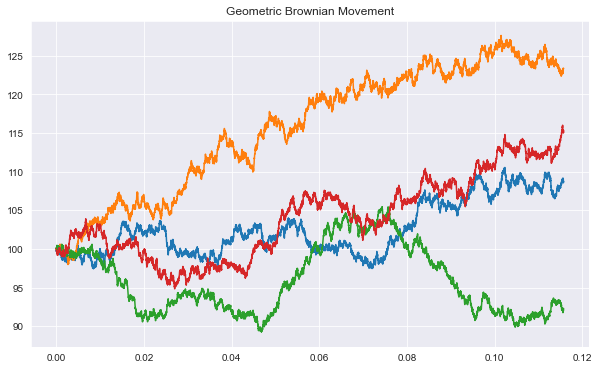

Correlation of the computed GBM : 
 [[ 1.         -0.01338777 -0.3881096   0.2917603 ]
 [-0.01338777  1.         -0.19230877  0.08504023]
 [-0.3881096  -0.19230877  1.          0.00339805]
 [ 0.2917603   0.08504023  0.00339805  1.        ]]
Input correlation : 
 [[ 1.   0.  -0.4  0.3]
 [ 0.   1.  -0.2  0.1]
 [-0.4 -0.2  1.   0. ]
 [ 0.3  0.1  0.   1. ]]


In [7]:
n = 10000
mu = [0.01, 0.01, 0.01, 0.01]
sigmas = [np.sqrt(0.1), np.sqrt(0.1), np.sqrt(0.1), np.sqrt(0.1)]
corrs = [[1, 0, -0.4, 0.3], [0, 1, -0.2, 0.1], [-0.4, -0.2, 1, 0], [0.3, 0.1, 0, 1]]
Cov = cov_matrix(sigmas, corrs)
start_price = [100, 100, 100, 100]
dt = 1/86400

d = len(mu)

time_vect = [i*dt for i in range(n)]

S = GBM(mu, Cov, start_price, time_vect)

plt.figure(figsize=(10,6))
for i in range(d) :
    plt.plot(time_vect, S[i])
plt.title("Geometric Brownian Movement")
plt.show()
print("Correlation of the computed GBM :", '\n', np.corrcoef(np.diff(np.log(S))))
print("Input correlation :", '\n', np.array(corrs))